# Sparse dense matmul with PopSparse on IPU

<small>Copyright (c) 2023 Graphcore Ltd.</small>

This tutorial will walk you through how to use PopSparse and Poptorch for sparse dense matmul (SpMM).
The detailed benchmark results and discussion can be found in the paper:

PopSparse: Accelerated block sparse matrix multiplication on IPU
(arxiv link)

The SpMM can be written as:
\begin{align*}
    Y &= (M \odot W) * X \,,\\
    M_{ij} &= \hat{M}_{\lfloor i/b \rfloor, \lfloor j/b \rfloor} \,,
\end{align*}
where $\odot$ denotes elementwise multiplication, $*$ for inner product, $Y \in \mathbb{R}^{m \times n}$, $X \in \mathbb{R}^{k \times n}$ are dense output and input matrices respectively. The sparse weight matrix $(M \odot W)$ is defined via $M \in \mathbb{B}^{m \times k}$ ($\mathbb{B} = \{0, 1\}$), a mask that represents the *sparsity pattern*, itself derived from $\hat{M} \in \mathbb{B}^{\lceil m/b \rceil \times \lceil k/b \rceil}$, a block mask and $W \in \mathbb{R}^{m \times k}$ defines weight values.

In this formulation, $(M \odot W)$ has a block-sparse structure, where contiguous square blocks of weights of shape $b \times b$ contain all the non-zero elements, given *block-size* $b$. The dimensions $m$ and $k$ are referred to as output and input *feature size* and  $n$ is referred to as *batch size*, corresponding to their typical role in weight-sparse neural network computation.

We define *density*, $d = \sum_{ij} M_{ij} / (m \cdot k)$, where the standard term *sparsity* corresponds to $(1 - d)$. We use floating point operation (FLOP) count to quantify the amount of useful arithmetic work in an SpMM as: $2\cdot m\cdot k\cdot n\cdot d$. Note that this only counts operations performed on non-zero values and does not depend on block size $b$.

In this notebook, we demonstrate the SpMM with PopSparse on IPU with static (main focus) and dynamic sparsity; elementwise (block size = 1) and block sparse. We compare the performance of sparse operations with its equivalent dense calculation. We start with an introduction using small matrices and show the comparison using large matrices at the end.

**Note** that the throughput numbers reported in the paper is run on IPU Bow machine. If you are running the notebook on a classic machine, the performance will be ~30% less. You can use `gc-monitor` on the command line to check the IPU clock frequency when there is a matmul running on IPU. The Bow IPU should be 1850MHz and classic is 1325MHz.

## Importing modules and functions

Install modules in requirements

In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Importing modules and PopTorch

In [17]:
import torch
import poptorch
import time
import tabulate
import matplotlib.pyplot as pyplot
from typing import Callable

Build the SpMM custom ops (static and dynamic) based on PopSparse libray so that we could use them in the PopTorch models.

In [3]:
%%bash
make -C poptorch_static_sparse
make -C poptorch_dynamic_sparse


make: Entering directory '/nethome/zhiyil/git/sw_apps_sandbox/sparsity_demo/poptorch_static_sparse'
make: 'libpoptorch_static_sparse_op.so' is up to date.
make: Leaving directory '/nethome/zhiyil/git/sw_apps_sandbox/sparsity_demo/poptorch_static_sparse'
make: Entering directory '/nethome/zhiyil/git/sw_apps_sandbox/sparsity_demo/poptorch_dynamic_sparse'
make: 'build/libpoptorch_dynamic_sparse_op.so' is up to date.
make: Leaving directory '/nethome/zhiyil/git/sw_apps_sandbox/sparsity_demo/poptorch_dynamic_sparse'


Importing the SpMM custom ops

In [4]:
import poptorch_static_sparse.poptorch_static_sparse_op as static_sparse_op
import poptorch_dynamic_sparse.poptorch_dynamic_sparse_op as dynamic_sparse_op
from poptorch_static_sparse.poptorch_static_sparse_op import magnitude_prune 

## Example with small matrices
Let's generate two random matrices and prune the left hand side matrix to be a sparse matrix:

Set the hyperparameters of the sparse and dense matrix

In [18]:
block_size = 1 # block size of the sparse matrix b
shape = [5, 5] # block row and column of the sparse matrix mb * kb (m = mb * b, k = kb * b)
batch_size = 4 # batch size of the dense matrix n
density = 0.5 # density = (1 - sparsity) of the sparse matrix, d
dtype = torch.float
num_loops = 2000 # loop count in the poptprch for_loop to run for timing
num_exe = 2 # number of execution, fixed to be 2: first time for warming up (compilation etc.), second time for timing
seed = 1999
torch.manual_seed(seed);

We generate the left hand side (lhs) and right hand side (rhs) of the matrix multiplication.

In [6]:
def generate_lhs_rhs_matrix(shape, block_size, batch_size, dtype):
    lhs = torch.randn((shape[0] * block_size, shape[1] * block_size), dtype=dtype)
    lhs /= lhs.shape[1] ** 0.5 
    rhs = torch.randn((shape[1] * block_size, batch_size), dtype=dtype)
    return lhs, rhs
lhs, dense = generate_lhs_rhs_matrix(shape, block_size, batch_size, dtype)

We prune the lhs matrix and get our sparse matrix.

In [7]:
sparse = magnitude_prune(lhs.to(dtype), block_size, density)

We could have a look at the original left hand side matrix in dense form:

In [8]:
lhs

tensor([[ 0.1257,  0.1839,  0.1565,  0.5638,  0.1385],
        [-0.6040, -0.0577,  0.0542, -0.1277, -0.1356],
        [-0.1255, -0.4487,  0.2926, -0.4057, -0.5863],
        [ 0.4124,  0.1301, -0.2613, -0.1388, -0.4322],
        [-0.0492,  0.6213, -0.6681,  0.3652, -0.3116]])

The pruned lhs, which shows in sparse format:

In [9]:
sparse

tensor(indices=tensor([[0, 1, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4],
                       [3, 0, 1, 2, 3, 4, 0, 4, 1, 2, 3, 4]]),
       values=tensor([[[ 0.5638]],

                      [[-0.6040]],

                      [[-0.4487]],

                      [[ 0.2926]],

                      [[-0.4057]],

                      [[-0.5863]],

                      [[ 0.4124]],

                      [[-0.4322]],

                      [[ 0.6213]],

                      [[-0.6681]],

                      [[ 0.3652]],

                      [[-0.3116]]]),
       size=(5, 5, 1, 1), nnz=12, layout=torch.sparse_coo)

The sparse matrix in dense format (we can spot the zeros after pruning):

In [10]:
sparse_dense_matrix = static_sparse_op.block_coo_to_dense(sparse)
sparse_dense_matrix

tensor([[ 0.0000,  0.0000,  0.0000,  0.5638,  0.0000],
        [-0.6040,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.4487,  0.2926, -0.4057, -0.5863],
        [ 0.4124,  0.0000,  0.0000,  0.0000, -0.4322],
        [ 0.0000,  0.6213, -0.6681,  0.3652, -0.3116]])

The right hand side dense matrix:

In [11]:
dense

tensor([[ 0.3168, -0.7362, -2.2414, -0.6063],
        [ 0.2821, -0.8316,  0.2504,  1.9486],
        [-0.0178,  0.5444, -0.5707, -1.3101],
        [-0.6667,  0.5962, -0.4849,  1.1735],
        [ 0.0036, -0.3892, -0.6853, -0.4562]])

We create PyTorch models for the sparse(static and dynamic) SpMM and dense matmul.

In [12]:
class DemoSparseModel(torch.nn.Module):
    """A tiny demo model for SpMM with PopSparse."""

    def __init__(self, sparse: torch.Tensor, custom_op: Callable, loop_count: int):
        super().__init__()
        self.sparse = sparse
        self.loop_count = loop_count
        self.custom_op = custom_op

    def forward(self, input: torch.Tensor)  -> torch.Tensor:
        if self.loop_count > 1:
            return poptorch.for_loop(
                self.loop_count, lambda dense: self.custom_op(self.sparse, dense), [input]
            )[0]
        return self.custom_op(self.sparse, input)

In [13]:
class DemoDenseModel(torch.nn.Module):
    """A tiny demo model for dense matmul."""

    def __init__(self, sparse_dense_matrix: torch.Tensor, loop_count: int):
        super().__init__()
        self.sparse_dense_matrix = sparse_dense_matrix
        self.loop_count = loop_count

    def forward(self, input: torch.Tensor)  -> torch.Tensor:
        if self.loop_count > 1:
            return poptorch.for_loop(
                self.loop_count, lambda dense: [torch.matmul(self.sparse_dense_matrix.to(device="ipu"), dense)], [input]
            )[0]
        return torch.matmul(self.sparse_dense_matrix.to(device="ipu"), input)

Let's run the SpMM using the torch gather scatter method (gather_scatter) on CPU and PopSparse SpMM custom ops static_sparse_op and dynamic_sparse_op (inference_model) on IPU

In [14]:
outputs = {}
durations = {}

In [15]:
if dtype != torch.half:
    for i in range(num_loops+num_exe):
        if i == num_exe:
            start_gs = time.time()
        outputs["gather_scatter"] = static_sparse_op.block_coo_spmm_gs(
            sparse, dense, mode="sparse_dense"
        )
    durations["duration_gs"] = (time.time() - start_gs) / num_loops
print(durations)

{'duration_gs': 0.00024115920066833496}


We create the static_sparse_model with the custom op `static_sparse_op.block_coo_spmm_ipu` and convert the model to be an PopTorch inference model using `poptorch.inferenceModel`.

In [16]:
static_sparse_model = DemoSparseModel(sparse, static_sparse_op.block_coo_spmm_ipu, loop_count=1)
options = poptorch.Options()
options.Precision.setPartialsType(torch.half)
ipu_model_static_sparse = poptorch.inferenceModel(static_sparse_model, options)

for i in range(num_exe):
    if i == 0:
        out = ipu_model_static_sparse(dense) # run for graph compilation
    elif i == num_exe - 1:
        start_spmm = time.time()
        outputs["inference_model_static"] = ipu_model_static_sparse(dense) # run without graph compilation
durations["duration_spmm_static"] = (time.time() - start_spmm) / num_loops    

Graph compilation: 100%|██████████| 100/100 [00:03<00:00]


Same with dynamic SpMM, we create the dynamic_sparse_model with the custom op `dynamic_sparse_op.dynamic_spmm_ipu` and convert it to PopTorch inference model.

In [17]:
dynamic_sparse_model = DemoSparseModel(sparse, dynamic_sparse_op.dynamic_spmm_ipu, loop_count=1)
options = poptorch.Options()
options.Precision.setPartialsType(torch.half)
ipu_model_dynamic_sparse = poptorch.inferenceModel(dynamic_sparse_model, options)

for i in range(num_exe):
    if i == 0:
        out = ipu_model_dynamic_sparse(dense) # run once for graph compilation
    elif i == num_exe - 1:
        start_spmm = time.time()
        outputs["inference_model_dynamic"] = ipu_model_dynamic_sparse(dense) # run num_loops without graph compilation
durations["duration_spmm_dynamic"] = (time.time() - start_spmm) / num_loops


Graph compilation: 100%|██████████| 100/100 [00:05<00:00]


We also run the dense one as a reference:

In [18]:
sparse_dense_matrix = static_sparse_op.block_coo_to_dense(sparse)
dense_model = DemoDenseModel(sparse_dense_matrix, loop_count=1)
options = poptorch.Options()
ipu_dense_model = poptorch.inferenceModel(dense_model, options)

for i in range(num_exe):
    if i == 0:
        out = ipu_dense_model(dense) # run for graph compilation
    elif i == num_exe - 1:
        start_spmm = time.time()
        outputs["inference_dense"] = ipu_dense_model(dense) # run without graph compilation
durations["duration_dense"] = (time.time() - start_spmm) / num_loops
print(durations)

Graph compilation: 100%|██████████| 100/100 [00:03<00:00]


{'duration_gs': 0.00024115920066833496, 'duration_spmm_static': 4.029273986816406e-07, 'duration_spmm_dynamic': 2.7751922607421873e-07, 'duration_dense': 2.4974346160888674e-07}


We could examine the output from the gather scatter method and from the PopTorch inference models to make sure they give equal output.

In [19]:
# output from CPU gather scatter
outputs["gather_scatter"] # shape seems to be different with inference model

tensor([[-0.3758,  0.3361, -0.2734,  0.6615],
        [-0.1913,  0.4446,  1.3538,  0.3662],
        [ 0.1365,  0.5188,  0.3191, -1.4664],
        [ 0.1291, -0.1354, -0.6283, -0.0529],
        [-0.0575, -0.5414,  0.5733,  2.6567]])

In [20]:
# inference model output from static sparse
outputs["inference_model_static"]

tensor([[-0.3758,  0.3361, -0.2734,  0.6615],
        [-0.1913,  0.4446,  1.3538,  0.3662],
        [ 0.1365,  0.5188,  0.3191, -1.4664],
        [ 0.1291, -0.1354, -0.6283, -0.0529],
        [-0.0575, -0.5414,  0.5733,  2.6567]])

In [21]:
# inference model output from dynamic sparse
outputs["inference_model_dynamic"]

tensor([[-0.3758,  0.3361, -0.2734,  0.6615],
        [-0.1913,  0.4446,  1.3538,  0.3662],
        [ 0.1365,  0.5188,  0.3191, -1.4664],
        [ 0.1291, -0.1354, -0.6283, -0.0529],
        [-0.0575, -0.5414,  0.5733,  2.6567]])

In [22]:
# inference model output from dense
outputs["inference_dense"]

tensor([[-0.3758,  0.3361, -0.2734,  0.6615],
        [-0.1913,  0.4446,  1.3538,  0.3662],
        [ 0.1365,  0.5188,  0.3191, -1.4664],
        [ 0.1291, -0.1354, -0.6283, -0.0529],
        [-0.0575, -0.5414,  0.5733,  2.6567]])

We could also comapre the ouputs with the expected dense matmul calculated on CPU

In [23]:
expected_output = static_sparse_op.block_coo_to_dense(sparse).float() @ dense.float()
print(expected_output)

tensor([[-0.3758,  0.3361, -0.2734,  0.6615],
        [-0.1913,  0.4446,  1.3538,  0.3662],
        [ 0.1365,  0.5188,  0.3191, -1.4664],
        [ 0.1291, -0.1354, -0.6283, -0.0529],
        [-0.0575, -0.5414,  0.5733,  2.6567]])


## Visualize pruned matrix:

To have more visualization on the pruning process, we could use a slightly larger matrix and plot the matrix before and after pruning:

In [24]:
block_size = 4
shape = [3, 5]
batch_size = 4
density = 0.5
dtype = torch.float

In [25]:
lhs, dense = generate_lhs_rhs_matrix(shape, block_size, batch_size, dtype) # generate lhs and rhs
sparse = magnitude_prune(lhs.to(dtype), block_size, density) # prune lhs
sparse_dense = static_sparse_op.block_coo_to_dense(sparse) # convert lhs back to dense form

We could see that with the pruned sparse matrix, almost half (density 0.5) of the 4 x 4 blocks are zeros. 

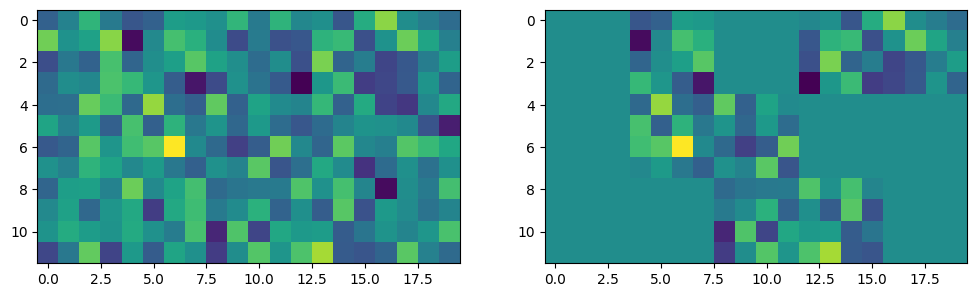

In [26]:
_, (ax0, ax1) = pyplot.subplots(1, 2, figsize=(12, 4))
ax0.imshow(lhs)
ax1.imshow(sparse_dense)

## Sparse dense matmul with large matrices

Now we generate much larger matrices to get some throughput numbers in TFLOPS:

In [27]:
block_size = 1
shape = [4096, 4096]
batch_size = 512
density = 1/64
dtype = torch.float

In [28]:
lhs, dense = generate_lhs_rhs_matrix(shape, block_size, batch_size, dtype) # generate lhs and rhs
sparse = magnitude_prune(lhs.to(dtype), block_size, density) # prune lhs

Run the model with PyTorch gather scatter on cpu, dense multiplication on IPU and PopSparse SpMM on IPU. 

In [29]:
durations_large_matrix = {}

gather scatter on cpu

In [30]:
def gather_scatter_cpu(sparse, dense):
    if dtype != torch.half:
        for i in range(num_loops+num_exe):
            if i == num_exe:
                start_gs = time.time()
            output = static_sparse_op.block_coo_spmm_gs(
                sparse, dense, mode="sparse_dense"
            )
        duration = (time.time() - start_gs) / num_loops
    return output, duration

In [31]:
_, duration = gather_scatter_cpu(sparse, dense)
durations_large_matrix["duration_gs"] = duration

convert sparse matrix to dense format and run matrix multiplication on IPU

In [32]:
def dense_matmul_ipu(sparse, dense):
    sparse_dense_matrix = static_sparse_op.block_coo_to_dense(sparse)
    static_sparse_model = DemoDenseModel(sparse_dense_matrix, loop_count=num_loops)
    options = poptorch.Options()
    options.Precision.setPartialsType(torch.half)
    ipu_model_static_sparse = poptorch.inferenceModel(static_sparse_model, options)

    for i in range(num_exe):
        if i == 0:
            out = ipu_model_static_sparse(dense) # run for graph compilation
        elif i == num_exe - 1:
            start_spmm = time.time()
            output = ipu_model_static_sparse(dense) # run without graph compilation
    duration = (time.time() - start_spmm) / num_loops 
    return output, duration

In [33]:
_, duration = dense_matmul_ipu(sparse, dense)
durations_large_matrix["duration_dense"] = duration

Graph compilation: 100%|██████████| 100/100 [00:27<00:00]


SpMM on IPU

We define the functions to run static and dynamic SpMM on IPU.

In [34]:
def sparse_matmul_static_ipu(sparse, dense):
    static_sparse_model = DemoSparseModel(sparse, static_sparse_op.block_coo_spmm_ipu, loop_count=num_loops)
    options = poptorch.Options()
    options.Precision.setPartialsType(torch.half)
    ipu_model_static_sparse = poptorch.inferenceModel(static_sparse_model, options)

    for i in range(num_exe):
        if i == 0:
            output = ipu_model_static_sparse(dense) # run for graph compilation
        elif i == num_exe - 1:
            start_spmm = time.time()
            output = ipu_model_static_sparse(dense) # run without graph compilation
    duration = (time.time() - start_spmm) / num_loops 
    return output, duration

In [35]:
def sparse_matmul_dynamic_ipu(sparse, dense):
    static_sparse_model = DemoSparseModel(sparse, dynamic_sparse_op.dynamic_spmm_ipu, loop_count=num_loops)
    options = poptorch.Options()
    options.Precision.setPartialsType(torch.half)
    ipu_model_static_sparse = poptorch.inferenceModel(static_sparse_model, options)

    for i in range(num_exe):
        if i == 0:
            output = ipu_model_static_sparse(dense) # run for graph compilation
        elif i == num_exe - 1:
            start_spmm = time.time()
            output = ipu_model_static_sparse(dense) # run without graph compilation
    duration = (time.time() - start_spmm) / num_loops 
    return output, duration

In [36]:
def sparse_matmul_static_ipu_profiles(sparse, dense, num_loops):
    static_sparse_model = DemoSparseModel(sparse, static_sparse_op.block_coo_spmm_ipu, loop_count=num_loops)
    options = poptorch.Options()
    options.Precision.setPartialsType(torch.half)
    ipu_model_static_sparse = poptorch.inferenceModel(static_sparse_model, options)
    output = ipu_model_static_sparse(dense)
    return output

Now we run the static SpMM and save the duration to the dict of durations_large_matrix.

In [37]:
_, duration = sparse_matmul_static_ipu(sparse, dense)
durations_large_matrix["duration_spmm_static"] = duration

Graph compilation: 100%|██████████| 100/100 [00:19<00:00]


Dynamic SpMM

In [38]:
_, duration = sparse_matmul_dynamic_ipu(sparse, dense)
durations_large_matrix["duration_spmm_dynamic"] = duration

Graph compilation: 100%|██████████| 100/100 [00:11<00:00]


Now we could compare the throughput with all the three models. We convert the FLOP to TFLOP to better quantify the results. Also note that for dense throughput calculation, we include only non-zero flops.

In [39]:
def calculate_tflop(density, shape, block_size, batch_size):
    nnz = int(density * shape[0] * block_size * shape[1] * block_size)
    num_blocks = int(nnz / (block_size * block_size))
    tflop = 2.0 * batch_size * block_size * block_size * num_blocks / 10**12
    return tflop
tflop = calculate_tflop(density, shape, block_size, batch_size)
print(f"Number of TFLOP: {tflop}")

Number of TFLOP: 0.000268435456


Now we could calculate the FLOPS values for gather scatter on cpu, static and dynamic SpMM as well as dense matmul on IPU. We also show the comparison between static_sparse vs. dense and dynamic_sparse vs. dense. From the results we could see that the static sparse gain substantial advantage (~3 times the dense regarding FLOPS) wih the test case. The dynamic sparse is also slightly faster than dense (~1.5 times).

In [40]:
flops_gs = (tflop / durations_large_matrix["duration_gs"])
flops_dense = (tflop / durations_large_matrix["duration_dense"])
flops_spmm_static = (tflop / durations_large_matrix["duration_spmm_static"])
flops_spmm_dynamic = (tflop / durations_large_matrix["duration_spmm_dynamic"])
sparse_dense_tput_ratio_static = flops_spmm_static / flops_dense
sparse_dense_tput_ratio_dynamic = flops_spmm_dynamic / flops_dense

print(f"Throughput for different operations:")
print(tabulate.tabulate([("Gather scatter", flops_gs, "TFLOP/s"), ("Dense matmul", flops_dense, "TFLOP/s"),
                         ("Static SpMM", flops_spmm_static, "TFLOP/s"), ("Dynamic SpMM", flops_spmm_dynamic, "TFLOP/s")]))

print(f"Static sparse/dense throughput on IPU: {sparse_dense_tput_ratio_static :.3g}")
print(f"Dynamic sparse/dense throughput on IPU: {sparse_dense_tput_ratio_dynamic :.3g}")

Throughput for different operations:
--------------  ----------  -------
Gather scatter  0.00125717  TFLOP/s
Dense matmul    0.81948     TFLOP/s
Static SpMM     3.13993     TFLOP/s
Dynamic SpMM    1.30075     TFLOP/s
--------------  ----------  -------
Static sparse/dense throughput on IPU: 3.83
Dynamic sparse/dense throughput on IPU: 1.59


## Micro benchmark with dense matmul and SpMM on IPU

### Block size = 1, data type: half

In [41]:
block_size = 1 # block size of the sparse matrix
shape = [4096,4096] # block row and column of the sparse matrix
batch_size = 1024 # batch size of the dense matrix
dtype = torch.half

Define a function for benchmarking and printing some throughput and comparison numbers.

In [42]:
durations_large_matrix_block = {"duration_dense": None, "duration_spmm_static": None}
def benchmark_and_print(block_size, shape, batch_size, density, dtype):
      # print basic matrices info
      print(f"m = {shape[0]*block_size}, k = {shape[1]*block_size}, n = {batch_size}, "
            f"b = {block_size}, d = {density}, dtype = {dtype}")
      # generate matrices  
      lhs, dense = generate_lhs_rhs_matrix(shape, block_size, batch_size, dtype)
      sparse = magnitude_prune(lhs.to(dtype), block_size, density)
      # run dense matmul if dense was not run before
      if not durations_large_matrix_block["duration_dense"]:
            _, duration = dense_matmul_ipu(sparse, dense)
            durations_large_matrix_block["duration_dense"] = duration
      # run SpMM
      _, duration = sparse_matmul_static_ipu(sparse, dense)
      durations_large_matrix_block["duration_spmm_static"] = duration
      # calculate flops
      tflop = calculate_tflop(density, shape, block_size, batch_size)
      flops_spmm_static = (tflop / durations_large_matrix_block["duration_spmm_static"])
      flops_dense = (tflop / durations_large_matrix_block["duration_dense"])
      sparse_dense_tput_ratio_static = flops_spmm_static / flops_dense
      # print throughput and sparse/dense throughput ratio
      print(f"Throughput for different operations:")
      print(tabulate.tabulate([("Dense matmul", flops_dense, "TFLOP/s"),
                              ("Static SpMM", flops_spmm_static, "TFLOP/s")]))
      print(f"Static sparse/dense throughput on IPU: {sparse_dense_tput_ratio_static :.3g}")

Bnechmark for static SpMM with various densities.

**density = 1/64**

In [43]:
density = 1/64
benchmark_and_print(block_size, shape, batch_size, density, dtype)

m = 4096, k = 4096, n = 1024, b = 1, d = 0.015625, dtype = torch.float16


Graph compilation: 100%|██████████| 100/100 [00:19<00:00]


Throughput for different operations:
------------  -------  -------
Dense matmul  3.08973  TFLOP/s
Static SpMM   6.16198  TFLOP/s
------------  -------  -------
Static sparse/dense throughput on IPU: 1.99


**density = 1/32**

In [44]:
density = 1/32
benchmark_and_print(block_size, shape, batch_size, density, dtype)

m = 4096, k = 4096, n = 1024, b = 1, d = 0.03125, dtype = torch.float16


Graph compilation: 100%|██████████| 100/100 [00:21<00:00]


Throughput for different operations:
------------  -------  -------
Dense matmul  6.17946  TFLOP/s
Static SpMM   8.20761  TFLOP/s
------------  -------  -------
Static sparse/dense throughput on IPU: 1.33


**density = 1/16**

In [45]:
density = 1/16
benchmark_and_print(block_size, shape, batch_size, density, dtype) # reference: 10.50

m = 4096, k = 4096, n = 1024, b = 1, d = 0.0625, dtype = torch.float16


Graph compilation: 100%|██████████| 100/100 [00:24<00:00]


Throughput for different operations:
------------  -------  -------
Dense matmul  12.3589  TFLOP/s
Static SpMM   10.2345  TFLOP/s
------------  -------  -------
Static sparse/dense throughput on IPU: 0.828


**density = 1/8**

In [46]:
density = 1/8
benchmark_and_print(block_size, shape, batch_size, density, dtype) # reference: 11.77

m = 4096, k = 4096, n = 1024, b = 1, d = 0.125, dtype = torch.float16


Graph compilation: 100%|██████████| 100/100 [00:28<00:00]


Throughput for different operations:
------------  -------  -------
Dense matmul  24.7178  TFLOP/s
Static SpMM   11.4647  TFLOP/s
------------  -------  -------
Static sparse/dense throughput on IPU: 0.464


With block size = 1, static sparse is faster than dense matmul when density is low: for example, density = 1/64 and 1/32. 
Next, let's have a look at the case with large block size.

### Block size = 16, data type = half

In [47]:
block_size = 16 # block size of the sparse matrix
shape = [256, 256] # block row and column of the sparse matrix
batch_size = 2048 # batch size of the dense matrix
dtype = torch.half
durations_large_matrix_block = {"duration_dense": None, "duration_spmm_static": None}

**density = 1/64**

In [48]:
density = 1/64
benchmark_and_print(block_size, shape, batch_size, density, dtype)

m = 4096, k = 4096, n = 2048, b = 16, d = 0.015625, dtype = torch.float16


Graph compilation: 100%|██████████| 100/100 [00:40<00:00]


Throughput for different operations:
------------  -------  -------
Dense matmul  3.29656  TFLOP/s
Static SpMM   5.1096   TFLOP/s
------------  -------  -------
Static sparse/dense throughput on IPU: 1.55


**density = 1/32**

In [49]:
density = 1/32
benchmark_and_print(block_size, shape, batch_size, density, dtype)

m = 4096, k = 4096, n = 2048, b = 16, d = 0.03125, dtype = torch.float16


Graph compilation: 100%|██████████| 100/100 [00:38<00:00]


Throughput for different operations:
------------  -------  -------
Dense matmul  6.59312  TFLOP/s
Static SpMM   9.06285  TFLOP/s
------------  -------  -------
Static sparse/dense throughput on IPU: 1.37


**density = 1/16**

In [50]:
density = 1/16
benchmark_and_print(block_size, shape, batch_size, density, dtype)

m = 4096, k = 4096, n = 2048, b = 16, d = 0.0625, dtype = torch.float16


Graph compilation: 100%|██████████| 100/100 [00:39<00:00]


Throughput for different operations:
------------  -------  -------
Dense matmul  13.1862  TFLOP/s
Static SpMM   18.0305  TFLOP/s
------------  -------  -------
Static sparse/dense throughput on IPU: 1.37


**density = 1/8**

In [51]:
density = 1/8
benchmark_and_print(block_size, shape, batch_size, density, dtype)

m = 4096, k = 4096, n = 2048, b = 16, d = 0.125, dtype = torch.float16


Graph compilation: 100%|██████████| 100/100 [00:38<00:00]


Throughput for different operations:
------------  -------  -------
Dense matmul  26.3725  TFLOP/s
Static SpMM   32.6905  TFLOP/s
------------  -------  -------
Static sparse/dense throughput on IPU: 1.24


We could see that with block size = 16, static sparse with all densities chosen are faster than dense matmul.

### Profiling the SpMM on IPU

We use the `POPLAR_ENGINE_OPTIONS` to profile the SpMM and turn off profiling after it is done. The profiles are saved to spmm_profile directory. You can use PopVision to visualize the memory profiles and execution traces.

In [52]:
%env POPLAR_ENGINE_OPTIONS={"autoReport.all":"true", "autoReport.directory":"./spmm_profile"}
output = sparse_matmul_static_ipu_profiles(sparse, dense, 5)
%env POPLAR_ENGINE_OPTIONS={"autoReport.all":"false"}

env: POPLAR_ENGINE_OPTIONS={"autoReport.all":"true", "autoReport.directory":"./spmm_profile"}


Graph compilation: 100%|██████████| 100/100 [00:22<00:00]


env: POPLAR_ENGINE_OPTIONS={"autoReport.all":"false"}


# Final thoughts

This notebook demonstrates fast elementwise and block sparsity using PopSparse for inference on IPU. We hope that this work shows that block sparsity is a promising method for achieving practical acceleration of sparse models and will motivate further investigation into effective block sparse pruning algorithms in the research community.

If you are actively pursuing research in sparsity that could benefit from IPU support please consider signing up for our [academic program](https://www.graphcore.ai/academics) where we support researchers to achieve great things using IPUs.